# Quantum-enhanced random kitchen sinks

The goal of this notebook is to present the third algorithm presented in [Fock State-enhanced Expressivity of Quantum Machine Learning Models](https://arxiv.org/abs/2107.05224). It is an implementation of a random kitchen sinks algorithm that uses a photonic quantum circuit as part of its routine.

Let's start by explaining what is the random kitchen sinks algorithm. Basically for each datapoint features x, we will use the random Fourier features z(x) defined such as:

$$
z(x) = \frac{1}{\sqrt R} \begin{pmatrix}
z_{w_1}(x) \\
z_{w_2}(x) \\
... \\
z_{w_R}(x)
\end{pmatrix}
$$
where each $z_{w_r}(x)$ is a randomized cosine function:
$$
z_{w_r}(x) = \sqrt2 \cos (\gamma [w_r \cdot x + b_r])
$$
where x is the D-dimensional input data, $w_r$ are D-dimensional random vectors sampled from a spherical Gaussian and $b_r$ are random scalars sampled from a uniform distribution:
$$
w_r \sim N_D(0, I) \quad b_r \sim Uniform(0, 2\pi)
$$
and $\gamma$ is a hyperparameter that will control the standard deviation of the Gaussian approximated afterwards. Once we have the random Fourier features for every point, we can approximate the Gaussian kernel for every pair of points by using a salar product:
$$
z(x) \cdot z(x') \approx k(x, x') = e^{-\frac{\gamma^2}{2}(x-x')^2}
$$
That is the random kitchen sinks approach.

## How will the photonic quantum circuit be used in this whole process ?
There are two different methods to use the quantum circuit. One involves training and the other does not. For both, the randomized input encoding for a data point x, i.e. $x_{r} = \gamma(w_r \cdot x + b_r)$ will be encoded in the quantum circuit.

- Method 1: The model will undergo optimization for the fitting task on the function $f(x_r) = \sqrt2 \cos (x_r)$. That way, the optimized hybrid model approximates $z_{w_r}(x_r)$ for each $x_r$.

- Method 2: The model is instantiated and directly used to approximate $z_{w_r}(x_r)$ without training.

From there, all that is left is to build $z(x)$ and approximate the Gaussian kernel with $z(x) \cdot z(x') \approx k(x, x')$.

## 0. Imports and prep

In [ ]:
# Import required libraries
import os

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import perceval as pcvl
import torch
import torch.nn as nn
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from merlin import ComputationSpace, MeasurementStrategy, QuantumLayer

We will need a class to keep track of the hyperparameters for this experiment. There are many of them and they are all explained in the README.md file present in the q_rand_kitchen_sinks folder except for the **decision_boundary_output** which is only needed for this notebook.

- **decision_boundary_output** : (str) --> ['show', 'save'] If 'show', the decision boundary is simply shown as cell output. If 'save', then a directory './results/' is created if not already present, and the figure is saved locally in it. This last feature is useful to merge all the different decision boundaries together in one image.

In [2]:
class Hyperparameters:
    def __init__(
        self,
        random_state=42,
        scaling="MinMax",
        num_photon=10,
        circuit="mzi",
        learning_rate=0.001,
        c=5,
        r=1,
        gamma=1,
        train_hybrid_model=True,
        pre_encoding_scaling=1.0,
        z_q_matrix_scaling=10,
        hybrid_model_data="Default",
        visu_losses=True,
        decision_boundary_output="show",
    ):
        self.random_state = random_state
        self.scaling = scaling
        self.num_photon = num_photon
        self.circuit = circuit
        self.learning_rate = learning_rate
        self.C = c
        self.r = r
        self.gamma = gamma
        self.train_hybrid_model = train_hybrid_model
        self.pre_encoding_scaling = pre_encoding_scaling
        self.z_q_matrix_scaling = z_q_matrix_scaling
        self.set_z_q_matrix_scaling_value()
        self.hybrid_model_data = hybrid_model_data
        self.visu_losses = visu_losses
        self.decision_boundary_output = decision_boundary_output

        self.w = None
        self.b = None

    def set_z_q_matrix_scaling_value(self):
        if isinstance(self.z_q_matrix_scaling, str):
            if self.z_q_matrix_scaling == "1/sqrt(R)":
                self.z_q_matrix_scaling_value = torch.tensor(1.0 / np.sqrt(self.r))
            elif self.z_q_matrix_scaling == "sqrt(R)":
                self.z_q_matrix_scaling_value = torch.tensor(np.sqrt(self.r))
            else:
                raise ValueError('z_q_matrix_scaling must be "1/sqrt(R)" or "sqrt(R)"')
        else:
            self.z_q_matrix_scaling_value = torch.tensor(self.z_q_matrix_scaling)

    def set_random(self, w, b):
        """
        Set values for random weights and biases. That is to keep the same values for the quantum and classical
        methods in order to fairly compare the two.
        """
        self.w = w
        self.b = b
        return

    def set_gamma(self, gamma):
        self.gamma = gamma
        return

    def set_r(self, r):
        self.r = r
        self.set_z_q_matrix_scaling_value()
        return


base_args = Hyperparameters()

## 1. Get the data and define the target function for the hybrid model

We will consider the moon dataset, by sklearn.

In [3]:
def get_moon_dataset(random_state):
    """
    Return moon dataset x and y.
    x : [n_samples, 2]
    y : [n_samples, ] of value 0 or 1
    """
    x, y = make_moons(n_samples=200, noise=0.2, random_state=random_state)
    return np.array(x), np.array(y)


def scale_dataset(x_train, x_test, scaling="MinMax"):
    if scaling == "Standard":
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
    elif scaling == "MinMax":
        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
    else:
        raise ValueError(f"Unknown scaling method: {scaling}")
    return x_train, x_test


def split_train_test(x, y, random_state):
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.4, random_state=random_state
    )
    return x_train, x_test, y_train, y_test


x, y = get_moon_dataset(base_args.random_state)
x_train, x_test, y_train, y_test = split_train_test(x, y, base_args.random_state)
x_train, x_test = scale_dataset(x_train, x_test, scaling=base_args.scaling)

Let's visualize the dataset.

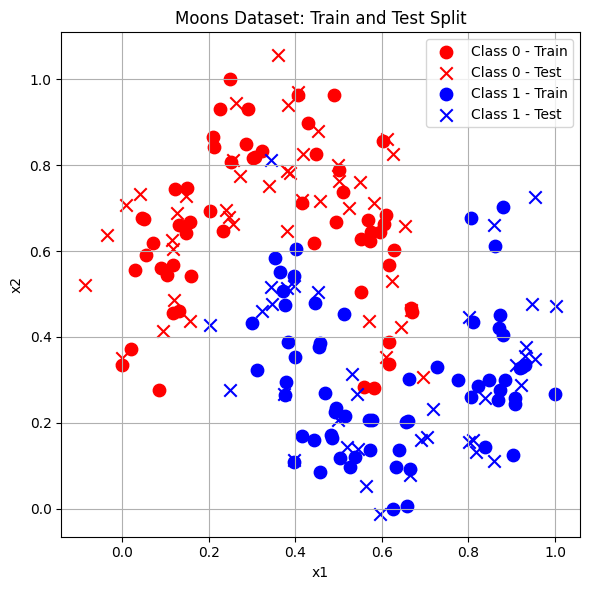

In [4]:
def visualize_dataset(x_train, x_test, y_train, y_test):
    plt.figure(figsize=(6, 6))

    # Plot training data (circle marker 'o')
    plt.scatter(
        x_train[y_train == 0][:, 0],
        x_train[y_train == 0][:, 1],
        color="red",
        marker="o",
        label="Class 0 - Train",
        s=80,
    )

    # Plot test data (cross marker 'x')
    plt.scatter(
        x_test[y_test == 0][:, 0],
        x_test[y_test == 0][:, 1],
        color="red",
        marker="x",
        label="Class 0 - Test",
        s=80,
    )

    plt.scatter(
        x_train[y_train == 1][:, 0],
        x_train[y_train == 1][:, 1],
        color="blue",
        marker="o",
        label="Class 1 - Train",
        s=80,
    )

    plt.scatter(
        x_test[y_test == 1][:, 0],
        x_test[y_test == 1][:, 1],
        color="blue",
        marker="x",
        label="Class 1 - Test",
        s=80,
    )

    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("Moons Dataset: Train and Test Split")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()
    return


visualize_dataset(x_train, x_test, y_train, y_test)

Let's define the target function for the hybrid model and visualize it.

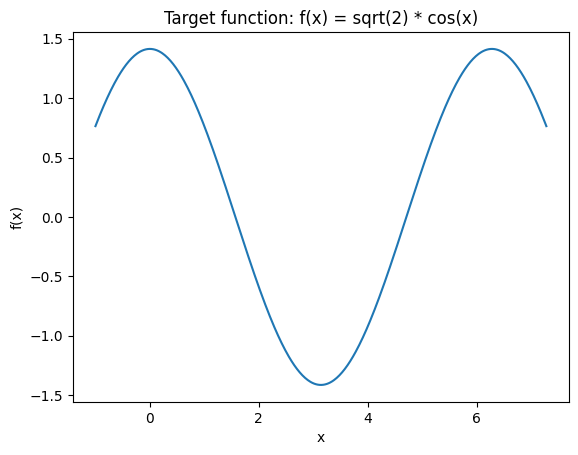

In [5]:
def get_target_function(x_r_i_s):
    return np.sqrt(2) * np.cos(x_r_i_s)


x = np.linspace(-1, 2 * np.pi + 1, 500)
plt.plot(x, get_target_function(x))
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Target function: f(x) = sqrt(2) * cos(x)")
plt.show()
plt.close()

## 2. Approximations and model definition

First off, let's define some functions useful for future approximations.

In [6]:
def get_random_w_b(r, random_state):
    np.random.seed(random_state)
    w = np.random.normal(size=(r, 2))
    b = np.random.uniform(low=0.0, high=2.0 * np.pi, size=(r,))

    return w, b


def get_x_r_i_s(x_s, w, b, r, gamma):
    """
    Given input data points x_s, of size [num_points, num_features],
    Return the x_{r, i}_s of size [num_points, r] such that
    x_{r, i} = gamma * (w_r * x_i + b_r)
    """
    num_points, num_features = x_s.shape

    x_r_i_s = gamma * (np.matmul(x_s, w.T) + np.tile(b, (num_points, 1)))
    assert x_r_i_s.shape == (num_points, r), f"Wrong shape for x_r_i_s: {x_r_i_s.shape}"

    return x_r_i_s


def get_z_s_classically(x_r_i_s):
    n, r = x_r_i_s.shape
    z_s = np.sqrt(2) * np.cos(x_r_i_s)
    z_s = z_s / np.sqrt(r)
    return z_s


def get_approx_kernel_train(z_s):
    result_matrix = np.matmul(z_s, z_s.T)
    assert result_matrix.shape == (z_s.shape[0], z_s.shape[0]), (
        f"Wrong shape for result_matrix: {result_matrix.shape}"
    )
    return result_matrix


def get_approx_kernel_predict(z_s_test, z_s_train):
    result_matrix = np.matmul(z_s_test, z_s_train.T)
    assert result_matrix.shape == (z_s_test.shape[0], z_s_train.shape[0]), (
        f"Wrong shape for result_matrix: {result_matrix.shape}"
    )
    return result_matrix

Next we define everything that is related to the hybrid model. That includes MerLin's QuantumLayer which allows backpropagation for optimization with gradient descent. It was also designed to be used with PyTorch so this facilitates its usage immensely.

In [7]:
def get_mzi():
    circuit = pcvl.Circuit(2)
    circuit.add(0, pcvl.BS())
    circuit.add(0, pcvl.PS(pcvl.P("data")))
    circuit.add(0, pcvl.BS())

    return circuit


def get_general():
    left_side = pcvl.GenericInterferometer(
        2,
        lambda i: (
            pcvl.BS()
            // pcvl.PS(phi=pcvl.P(f"theta_psl1{i}"))
            // pcvl.BS()
            // pcvl.PS(phi=pcvl.P(f"theta_{i}"))
        ),
        shape=pcvl.InterferometerShape.RECTANGLE,
    )
    right_side = pcvl.GenericInterferometer(
        2,
        lambda i: (
            pcvl.BS()
            // pcvl.PS(phi=pcvl.P(f"theta_psr1{i}"))
            // pcvl.BS()
            // pcvl.PS(phi=pcvl.P(f"theta_psr2{i}"))
        ),
        shape=pcvl.InterferometerShape.RECTANGLE,
    )

    circuit = pcvl.Circuit(2)
    circuit.add(0, left_side)
    circuit.add(0, pcvl.PS(pcvl.P("data")))
    circuit.add(0, right_side)
    return circuit


def get_circuit(args):
    if args.circuit == "mzi":
        return get_mzi(), []
    elif args.circuit == "general":
        return get_general(), ["theta"]
    else:
        raise ValueError(f"Wrong circuit type: {args.circuit}")


def save_circuit_locally(circuit, path):
    pcvl.pdisplay_to_file(circuit, path)
    return


def get_input_fock_state(num_photons):
    if num_photons % 2 == 0:
        return [int(num_photons / 2), int(num_photons / 2)]
    else:
        return [int(1 + (num_photons // 2)), int(num_photons // 2)]


def get_q_model(args):
    torch.manual_seed(args.random_state)

    input_fock_state = get_input_fock_state(int(args.num_photon))
    circuit, trainable_params = get_circuit(args)

    quantum_core = QuantumLayer(
        input_size=1,
        circuit=circuit,
        trainable_parameters=trainable_params,
        input_parameters=["data"],
        input_state=input_fock_state,
        measurement_strategy=MeasurementStrategy.probs(
            computation_space=ComputationSpace.FOCK
        ),  # Full Fock space for their experiment (2 modes, 10 photons)
    )

    return nn.Sequential(quantum_core, nn.Linear(quantum_core.output_size, 1))

## 3. Training function

The training here is separated in two blocks: first, we must train our hybrid model to approximate $f(x) = \sqrt 2 \cos (x)$ (or we can skip that part), then we must train a classical model that utilizes our approximated kernels. For that last part, we will use sklearn's SVC which allows us to use our precomputed kernel matrices.

### 3.1 Hybrid model
The optimization for the quantum model is as easy as for a classical PyTorch model thanks to MerLin. The structure of the training loop remains the same ! Note that the loss function used for this first training block is the Mean Squared Error (MSE) loss which is useful for regression tasks.

In [8]:
def training_q_model(x_train, x_test, args):
    # Transform data
    x_r_i_s_train_origin = get_x_r_i_s(x_train, args.w, args.b, args.r, args.gamma)
    x_r_i_s_test_origin = get_x_r_i_s(x_test, args.w, args.b, args.r, args.gamma)

    target_fit_train_origin = get_target_function(x_r_i_s_train_origin)
    target_fit_test_origin = get_target_function(x_r_i_s_test_origin)

    if args.hybrid_model_data == "Default":
        # 'Default' means we train the hybrid model on data from the moon dataset
        x_r_i_s_train = x_r_i_s_train_origin
        x_r_i_s_test = x_r_i_s_test_origin
    elif args.hybrid_model_data == "Generated":
        # 'Generated' means we train the hybrid model on more generated data from the same interval [min, max] as the original data from the moon dataset
        train_mins = x_r_i_s_train_origin.min(axis=0)  # shape (r,)
        train_maxs = x_r_i_s_train_origin.max(axis=0)  # shape (r,)
        test_mins = x_r_i_s_test_origin.min(axis=0)  # shape (r,)
        test_maxs = x_r_i_s_test_origin.max(axis=0)  # shape (r,)

        x_r_i_s_train = np.linspace(train_mins, train_maxs, 540, axis=0)
        x_r_i_s_test = np.linspace(test_mins, test_maxs, 100, axis=0)
    else:
        raise ValueError(f"Unknown hybrid_model_data: {args.hybrid_model_data}")

    target_fit_train = get_target_function(x_r_i_s_train)
    target_fit_test = get_target_function(x_r_i_s_test)

    assert x_r_i_s_train.shape == target_fit_train.shape, (
        f"Target fit shape is wrong for x_r_i_s_train: {target_fit_train.shape}"
    )
    assert x_r_i_s_train.shape == target_fit_train.shape, (
        f"Target fit shape is wrong for x_r_i_s_test: {target_fit_test.shape}"
    )

    q_model = get_q_model(args)
    print(q_model)
    # Count only trainable parameters
    trainable_params = sum(p.numel() for p in q_model.parameters() if p.requires_grad)
    print(f"Trainable parameters: {trainable_params}")

    dataset = TensorDataset(torch.Tensor(x_r_i_s_train), torch.Tensor(target_fit_train))
    dataloader = DataLoader(dataset, batch_size=30, shuffle=True)

    loss_f = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(
        q_model.parameters(),
        lr=args.learning_rate,
        betas=(0.99, 0.9999),
        weight_decay=0.0002,
    )
    epoch_bar = tqdm(range(200), desc="Training Epochs")
    best_previous_model = None
    best_previous_test_mse = np.inf
    losses = {"Train": [], "Test": []}

    for _ in epoch_bar:
        q_model.train()
        total_loss = 0

        for x_batch, y_batch in dataloader:
            optimizer.zero_grad()
            # Reformat input
            x_batch = x_batch.view(30 * args.r, -1) * torch.tensor(
                args.pre_encoding_scaling
            )
            logits = q_model(x_batch)
            # Reformat output
            logits = logits.view(30, args.r)
            loss = loss_f(logits, y_batch)
            loss.backward()

            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        losses["Train"].append(avg_loss)
        epoch_bar.set_postfix({"Train Loss": avg_loss})

        # Eval
        q_model.eval()
        eval_input = torch.Tensor(x_r_i_s_test).view(
            len(x_r_i_s_test) * args.r, -1
        ) * torch.tensor(args.pre_encoding_scaling)
        test_logits = q_model(eval_input)
        # Reformat
        test_logits = test_logits.view(len(x_r_i_s_test), args.r)
        test_loss = loss_f(test_logits, torch.Tensor(target_fit_test))
        epoch_bar.set_postfix({"Test Loss": test_loss})
        losses["Test"].append(test_loss.detach().numpy())

        if best_previous_model is None:
            best_previous_model = q_model
            best_previous_test_mse = test_loss
        elif test_loss < best_previous_test_mse:
            best_previous_model = q_model
            best_previous_test_mse = test_loss

    best_test_mse = np.min(losses["Test"])
    best_test_mse_epoch = np.argmin(losses["Test"])
    print(f"Best test MSE: {best_test_mse:.3f} at epoch {best_test_mse_epoch}")

    # We will keep and use the version of the q_model with the best test MSE
    q_model = best_previous_model

    return (
        q_model,
        losses,
        x_r_i_s_train_origin,
        x_r_i_s_test_origin,
        target_fit_train_origin,
        target_fit_test_origin,
    )


def visualize_losses(losses):
    """Plot training and test losses"""

    plt.figure(figsize=(7, 5))
    epochs = range(1, len(losses["Train"]) + 1)

    plt.plot(epochs, losses["Train"], label="Train Loss", color="blue")
    plt.plot(epochs, losses["Test"], label="Test Loss", color="red")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Test Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig('./results/loss_curve.png')  # To save locally
    plt.show()
    plt.close()
    return

However, we also have the option to not train the hybrid model with the following function.

In [9]:
def no_train_q_model(x_train, x_test, args):
    # Transform data
    x_r_i_s_train = get_x_r_i_s(x_train, args.w, args.b, args.r, args.gamma)
    x_r_i_s_test = get_x_r_i_s(x_test, args.w, args.b, args.r, args.gamma)

    target_fit_train = get_target_function(x_r_i_s_train)
    target_fit_test = get_target_function(x_r_i_s_test)

    assert x_r_i_s_train.shape == target_fit_train.shape, (
        f"Target fit shape is wrong for x_r_i_s_train: {target_fit_train.shape}"
    )
    assert x_r_i_s_train.shape == target_fit_train.shape, (
        f"Target fit shape is wrong for x_r_i_s_test: {target_fit_test.shape}"
    )

    q_model = get_q_model(args)

    return q_model, x_r_i_s_train, x_r_i_s_test, target_fit_train, target_fit_test

### 3.2 Random kitchen sinks
Next, we have the functions for the quantum-enhanced and classical random kitchen sinks algorithms.

In [10]:
def q_rand_kitchen_sinks(x_train, x_test, args):
    if args.train_hybrid_model:
        (
            q_model_opti,
            losses,
            x_r_i_s_train,
            x_r_i_s_test,
            target_fit_train,
            target_fit_test,
        ) = training_q_model(x_train, x_test, args)
        if args.visu_losses:
            visualize_losses(losses)
    else:
        q_model_opti, x_r_i_s_train, x_r_i_s_test, target_fit_train, target_fit_test = (
            no_train_q_model(x_train, x_test, args)
        )

    q_model_opti.eval()
    train_input = torch.Tensor(x_r_i_s_train).view(
        len(x_r_i_s_train) * args.r, -1
    ) * torch.tensor(args.pre_encoding_scaling)
    test_input = torch.Tensor(x_r_i_s_test).view(
        len(x_r_i_s_test) * args.r, -1
    ) * torch.tensor(args.pre_encoding_scaling)
    z_s_train = q_model_opti(train_input)
    z_s_test = q_model_opti(test_input)

    z_s_train = z_s_train.view(len(x_r_i_s_train), args.r)
    z_s_test = z_s_test.view(len(x_r_i_s_test), args.r)

    # In the paper, they multiply by 1/sqrt(R) but changing this value seems to give better results
    z_s_train = z_s_train * args.z_q_matrix_scaling_value
    z_s_test = z_s_test * args.z_q_matrix_scaling_value

    kernel_matrix_training = get_approx_kernel_train(z_s_train.detach().numpy())
    kernel_matrix_test = get_approx_kernel_predict(
        z_s_test.detach().numpy(), z_s_train.detach().numpy()
    )

    return q_model_opti, kernel_matrix_training, kernel_matrix_test


def classical_rand_kitchen_sinks(x_train, x_test, args):
    # Transform data
    x_r_i_s_train = get_x_r_i_s(x_train, args.w, args.b, args.r, args.gamma)
    x_r_i_s_test = get_x_r_i_s(x_test, args.w, args.b, args.r, args.gamma)

    z_s_train = get_z_s_classically(x_r_i_s_train)
    z_s_test = get_z_s_classically(x_r_i_s_test)

    kernel_matrix_training = get_approx_kernel_train(z_s_train)
    kernel_matrix_test = get_approx_kernel_predict(z_s_test, z_s_train)

    return kernel_matrix_training, kernel_matrix_test

Finally, we need to train the actual SVM and to visualize its decision boundary.

In [11]:
def visu_decision_boundary(
    svc, q_model_opti, x_train, x_test, y_train, y_test, acc, incorrect, args
):
    # Combine train and test for full visualization
    x_all = np.vstack((x_train, x_test))

    # Build a meshgrid over the 2D input space
    h = 0.02  # mesh step size
    x_min, x_max = x_all[:, 0].min() - 0.2, x_all[:, 0].max() + 0.2
    y_min, y_max = x_all[:, 1].min() - 0.2, x_all[:, 1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Flatten grid to get (n_points, 2) shape
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    if q_model_opti is None:  # Classically compute the random kitchen sinks
        grid_r_i_s = get_x_r_i_s(grid_points, args.w, args.b, args.r, args.gamma)
        x_r_i_s_train = get_x_r_i_s(x_train, args.w, args.b, args.r, args.gamma)

        grid_z_s = get_z_s_classically(grid_r_i_s)
        z_s_train = get_z_s_classically(x_r_i_s_train)

        k_grid = get_approx_kernel_predict(grid_z_s, z_s_train)

        figure_name = (
            f"classical_rand_kitchen_sinks_R_{args.r}_sigma_{1.0 / args.gamma}.png"
        )
        figure_title = "Decision boundary of SVC with classical Random Kitchen Sinks"

    else:  # Quantumly approximate the random kitchen sinks
        grid_r_i_s = get_x_r_i_s(grid_points, args.w, args.b, args.r, args.gamma)
        x_r_i_s_train = get_x_r_i_s(x_train, args.w, args.b, args.r, args.gamma)

        grid_input = (
            torch.Tensor(grid_r_i_s).view(len(grid_r_i_s) * args.r, -1)
            * args.pre_encoding_scaling
        )
        train_input = (
            torch.Tensor(x_r_i_s_train).view(len(x_r_i_s_train) * args.r, -1)
            * args.pre_encoding_scaling
        )

        grid_z_s = q_model_opti(grid_input)
        z_s_train = q_model_opti(train_input)

        grid_z_s = grid_z_s.view(len(grid_r_i_s), args.r)
        z_s_train = z_s_train.view(len(x_r_i_s_train), args.r)

        # In the paper, their multiply by 1/sqrt(R)
        grid_z_s = grid_z_s * args.z_q_matrix_scaling_value
        z_s_train = z_s_train * args.z_q_matrix_scaling_value

        k_grid = get_approx_kernel_predict(
            grid_z_s.detach().numpy(), z_s_train.detach().numpy()
        )

        figure_name = f"q_rand_kitchen_sinks_R_{args.r}_sigma_{1.0 / args.gamma}.png"
        figure_title = (
            "Decision boundary of SVC with quantum approximated Random Kitchen Sinks"
        )

    # Predict on the kernelized grid
    z = svc.decision_function(k_grid)
    z = z.reshape(xx.shape)

    # Plotting
    plt.figure(figsize=(8, 6))
    cmap_light = ListedColormap(["#FFAAAA", "#AAAAFF"])

    # Decision boundary
    plt.contourf(xx, yy, z > 0, cmap=cmap_light, alpha=0.6)

    # Plot data points
    plt.scatter(
        x_train[y_train == 0][:, 0],
        x_train[y_train == 0][:, 1],
        color="red",
        label="Class 0 - Train",
        marker="o",
    )
    plt.scatter(
        x_test[y_test == 0][:, 0],
        x_test[y_test == 0][:, 1],
        color="red",
        label="Class 0 - Test",
        marker="x",
    )
    plt.scatter(
        x_train[y_train == 1][:, 0],
        x_train[y_train == 1][:, 1],
        color="blue",
        label="Class 1 - Train",
        marker="o",
    )
    plt.scatter(
        x_test[y_test == 1][:, 0],
        x_test[y_test == 1][:, 1],
        color="blue",
        label="Class 1 - Test",
        marker="x",
    )

    plt.scatter(
        x_test[incorrect][:, 0],
        x_test[incorrect][:, 1],
        color="black",
        label="Incorrectly predicted",
        marker="o",
        s=10,
    )

    plt.text(
        0.05,
        0.95,
        f"{acc:.3}",
        transform=plt.gca().transAxes,
        fontsize=40,
        fontweight="bold",
        verticalalignment="top",
    )

    if args.gamma == 1:
        s = f"R = {args.r}\n$\\sigma = 1$"
    else:
        s = f"R = {args.r}\n$\\sigma = 1 / {args.gamma}$"
    plt.text(
        0.05,
        0.05,
        s,
        transform=plt.gca().transAxes,
        fontsize=20,
        verticalalignment="bottom",
    )

    plt.title(figure_title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.tight_layout()

    if args.decision_boundary_output == "show":
        plt.show()
    elif args.decision_boundary_output == "save":
        os.makedirs("results", exist_ok=True)
        plt.savefig(f"./results/{figure_name}")

    plt.close()
    return


def train_svm(
    kernel_matrix_training,
    kernel_matrix_test,
    q_model_opti,
    x_train,
    x_test,
    y_train,
    y_test,
    args,
):
    svc = SVC(C=args.C, kernel="precomputed", random_state=args.random_state)
    svc.fit(kernel_matrix_training, y_train)
    preds = svc.predict(kernel_matrix_test)
    acc = accuracy_score(y_test, preds)
    incorrect = y_test != preds

    visu_decision_boundary(
        svc, q_model_opti, x_train, x_test, y_train, y_test, acc, incorrect, args
    )
    return acc

## 4. Running the algorithm

Let's start with a single run of the algorithm.

In [12]:
def run_single_gamma_r(x_train, x_test, y_train, y_test, args):
    # Get random features w and b for both methods
    w, b = get_random_w_b(args.r, args.random_state)
    args.set_random(w, b)

    q_model_opti, q_kernel_matrix_train, q_kernel_matrix_test = q_rand_kitchen_sinks(
        x_train, x_test, args
    )
    q_acc = train_svm(
        q_kernel_matrix_train,
        q_kernel_matrix_test,
        q_model_opti,
        x_train,
        x_test,
        y_train,
        y_test,
        args,
    )
    print(f"q_rand_kitchen_sinks acc: {q_acc}")

    kernel_matrix_train, kernel_matrix_test = classical_rand_kitchen_sinks(
        x_train, x_test, args
    )
    acc = train_svm(
        kernel_matrix_train,
        kernel_matrix_test,
        None,
        x_train,
        x_test,
        y_train,
        y_test,
        args,
    )
    print(f"rand_kitchen_sinks acc: {acc}")

    return

Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:00<00:00, 305.77it/s, Test Loss=tensor(0.0286, grad_fn=<MseLossBackward0>)]


Best test MSE: 0.029 at epoch 120


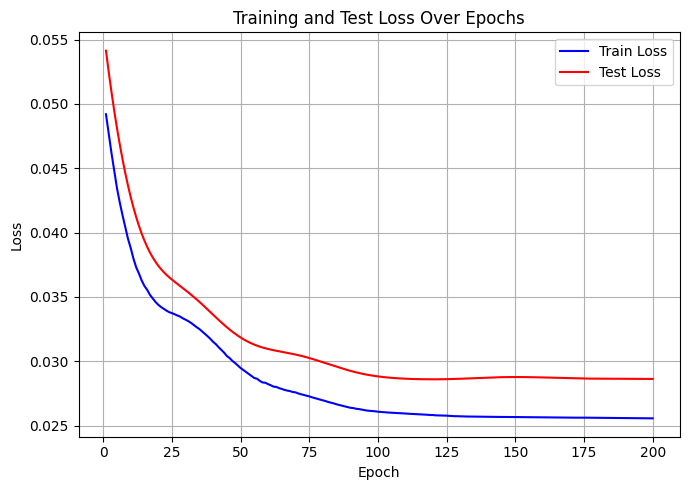

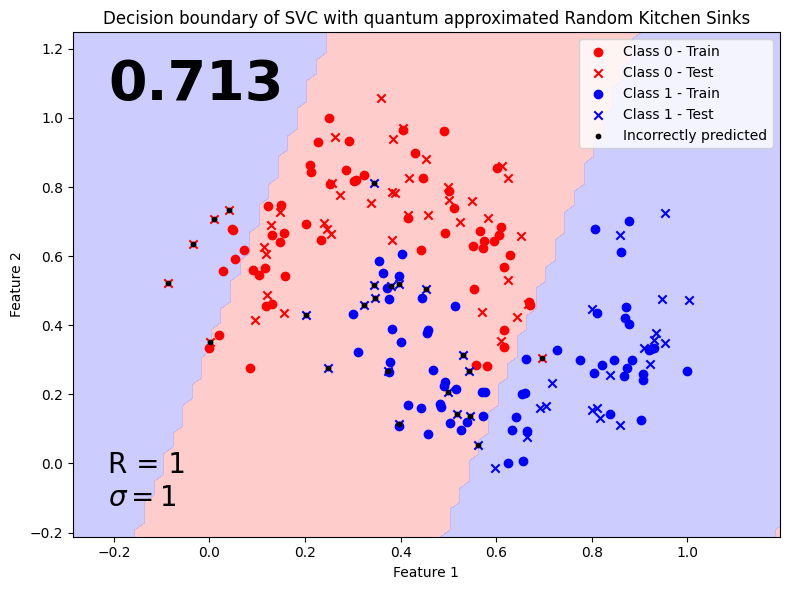

q_rand_kitchen_sinks acc: 0.7125


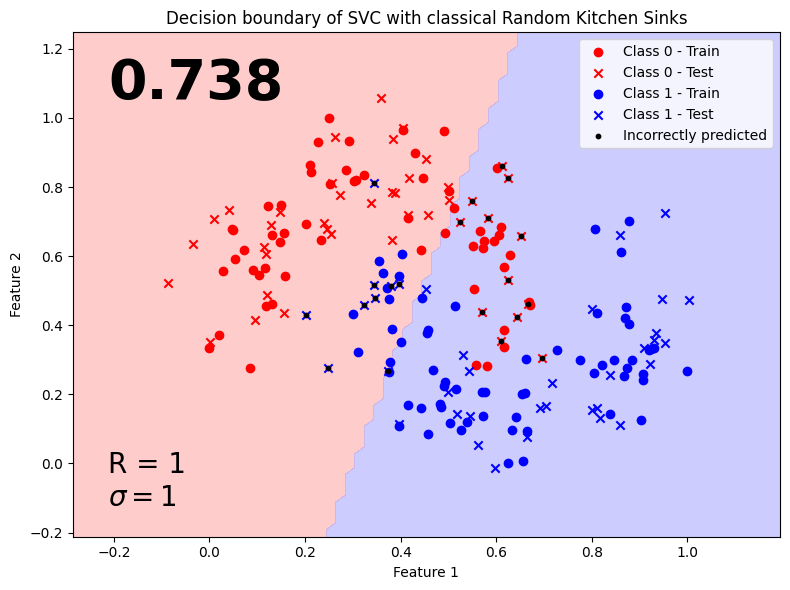

rand_kitchen_sinks acc: 0.7375


In [13]:
run_single_gamma_r(x_train, x_test, y_train, y_test, base_args)

Now that we know everything works, let's run the algorithm for several values of R and $\sigma$ (which is equal to $\frac{1}{\gamma}$). More specifically, we will run for $R \in [1, 10, 100]$ and $\gamma \in [1, 2, ... , 10]$. But first, we have to define some new functions just as helpers so that everything is clear.

In [14]:
def get_data(args):
    x, y = get_moon_dataset(args.random_state)
    x_train, x_test, y_train, y_test = split_train_test(x, y, args.random_state)
    x_train, x_test = scale_dataset(x_train, x_test, args.scaling)

    return x_train, x_test, y_train, y_test


def combine_saved_figures(q_approx=True):
    r_values = [1, 10, 100]
    gamma_values = list(range(1, 11))  # gamma from 1 to 10

    with plt.style.context("default"):
        fig, axes = plt.subplots(len(r_values), len(gamma_values), figsize=(15, 4))

        for i, r in enumerate(r_values):
            for j, gamma in enumerate(gamma_values):
                sigma = 1.0 / gamma
                if q_approx:
                    filename = f"q_rand_kitchen_sinks_R_{r}_sigma_{sigma}.png"
                else:
                    filename = f"classical_rand_kitchen_sinks_R_{r}_sigma_{sigma}.png"
                filepath = os.path.join("./results/", filename)

                if os.path.exists(filepath):
                    img = mpimg.imread(filepath)
                    ax = axes[i, j]
                    ax.imshow(img)
                    ax.axis("off")  # Hide axis ticks
                    if i == 0:
                        ax.set_title(f"γ = {gamma}", fontsize=10)
                    if j == 0:
                        ax.text(
                            0,
                            0.5,
                            f"R = {r}",
                            fontsize=10,
                            va="center",
                            ha="right",
                            transform=ax.transAxes,
                        )
                else:
                    print(f"Warning: {filepath} not found.")
        if q_approx:
            title = (
                "Decision Boundaries of SVC with Quantum-Enhanced Random Kitchen Sinks"
            )
        else:
            title = "Decision Boundaries of SVC with Classical Random Kitchen Sinks"

        fig.suptitle(title, fontsize=20)
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make room for the title
        plt.subplots_adjust(left=0.1, wspace=0.05, hspace=0.1)
        plt.show()
        plt.close()
    return

In [15]:
def run_different_gamma_r(args, type="quantum"):
    rs = [1, 10, 100]
    gammas = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    args.visu_losses = False
    args.decision_boundary_output = "save"

    for r in rs:
        args.set_r(r)
        for gamma in gammas:
            args.set_gamma(gamma)
            print("\n#############################")
            print(f"For r={r}, gamma={gamma}")

            # Get data
            x_train, x_test, y_train, y_test = get_data(args)

            w, b = get_random_w_b(args.r, args.random_state)
            args.set_random(w, b)

            if type == "quantum":
                q_model_opti, q_kernel_matrix_train, q_kernel_matrix_test = (
                    q_rand_kitchen_sinks(x_train, x_test, args)
                )
                q_acc = train_svm(
                    q_kernel_matrix_train,
                    q_kernel_matrix_test,
                    q_model_opti,
                    x_train,
                    x_test,
                    y_train,
                    y_test,
                    args,
                )
                print(f"q_rand_kitchen_sinks acc: {q_acc}")

            elif type == "classical":
                kernel_matrix_train, kernel_matrix_test = classical_rand_kitchen_sinks(
                    x_train, x_test, args
                )
                acc = train_svm(
                    kernel_matrix_train,
                    kernel_matrix_test,
                    None,
                    x_train,
                    x_test,
                    y_train,
                    y_test,
                    args,
                )
                print(f"rand_kitchen_sinks acc: {acc}")

    if type == "quantum":
        combine_saved_figures(True)
    elif type == "classical":
        combine_saved_figures(False)

    return

Method 1: First, let's try with a **non-trainable MZI** for quantum circuit and a **trained linear layer** afterwards for the quantum enhanced random kitchen sinks.


#############################
For r=1, gamma=1
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:00<00:00, 280.47it/s, Test Loss=tensor(0.0286, grad_fn=<MseLossBackward0>)]


Best test MSE: 0.029 at epoch 120
q_rand_kitchen_sinks acc: 0.7125

#############################
For r=1, gamma=2
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:00<00:00, 340.71it/s, Test Loss=tensor(0.0525, grad_fn=<MseLossBackward0>)]


Best test MSE: 0.053 at epoch 199
q_rand_kitchen_sinks acc: 0.6875

#############################
For r=1, gamma=3
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:00<00:00, 331.93it/s, Test Loss=tensor(0.2607, grad_fn=<MseLossBackward0>)]


Best test MSE: 0.261 at epoch 199
q_rand_kitchen_sinks acc: 0.725

#############################
For r=1, gamma=4
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:00<00:00, 339.65it/s, Test Loss=tensor(0.0455, grad_fn=<MseLossBackward0>)]


Best test MSE: 0.046 at epoch 199
q_rand_kitchen_sinks acc: 0.7375

#############################
For r=1, gamma=5
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:00<00:00, 338.30it/s, Test Loss=tensor(0.5304, grad_fn=<MseLossBackward0>)]


Best test MSE: 0.530 at epoch 199
q_rand_kitchen_sinks acc: 0.725

#############################
For r=1, gamma=6
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:00<00:00, 327.66it/s, Test Loss=tensor(0.1405, grad_fn=<MseLossBackward0>)]


Best test MSE: 0.140 at epoch 199
q_rand_kitchen_sinks acc: 0.725

#############################
For r=1, gamma=7
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:00<00:00, 348.57it/s, Test Loss=tensor(0.8670, grad_fn=<MseLossBackward0>)]


Best test MSE: 0.867 at epoch 199
q_rand_kitchen_sinks acc: 0.6125

#############################
For r=1, gamma=8
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:00<00:00, 343.65it/s, Test Loss=tensor(0.5209, grad_fn=<MseLossBackward0>)]


Best test MSE: 0.521 at epoch 199
q_rand_kitchen_sinks acc: 0.4625

#############################
For r=1, gamma=9
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:00<00:00, 327.12it/s, Test Loss=tensor(0.9582, grad_fn=<MseLossBackward0>)]


Best test MSE: 0.948 at epoch 13
q_rand_kitchen_sinks acc: 0.4625

#############################
For r=1, gamma=10
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:00<00:00, 339.41it/s, Test Loss=tensor(0.9875, grad_fn=<MseLossBackward0>)]


Best test MSE: 0.987 at epoch 160
q_rand_kitchen_sinks acc: 0.55

#############################
For r=10, gamma=1
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:01<00:00, 159.54it/s, Test Loss=tensor(1.2081, grad_fn=<MseLossBackward0>)]


Best test MSE: 1.208 at epoch 199
q_rand_kitchen_sinks acc: 0.9125

#############################
For r=10, gamma=2
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:01<00:00, 149.41it/s, Test Loss=tensor(0.8136, grad_fn=<MseLossBackward0>)]


Best test MSE: 0.814 at epoch 199
q_rand_kitchen_sinks acc: 0.95

#############################
For r=10, gamma=3
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:00<00:00, 206.89it/s, Test Loss=tensor(1.1109, grad_fn=<MseLossBackward0>)]


Best test MSE: 1.108 at epoch 99
q_rand_kitchen_sinks acc: 0.7

#############################
For r=10, gamma=4
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:01<00:00, 197.91it/s, Test Loss=tensor(0.9718, grad_fn=<MseLossBackward0>)]


Best test MSE: 0.961 at epoch 83
q_rand_kitchen_sinks acc: 0.8

#############################
For r=10, gamma=5
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:00<00:00, 218.11it/s, Test Loss=tensor(0.9100, grad_fn=<MseLossBackward0>)]


Best test MSE: 0.905 at epoch 60
q_rand_kitchen_sinks acc: 0.6875

#############################
For r=10, gamma=6
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:00<00:00, 200.48it/s, Test Loss=tensor(0.9298, grad_fn=<MseLossBackward0>)]


Best test MSE: 0.928 at epoch 135
q_rand_kitchen_sinks acc: 0.675

#############################
For r=10, gamma=7
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:00<00:00, 209.84it/s, Test Loss=tensor(0.9709, grad_fn=<MseLossBackward0>)]


Best test MSE: 0.969 at epoch 96
q_rand_kitchen_sinks acc: 0.675

#############################
For r=10, gamma=8
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:00<00:00, 220.05it/s, Test Loss=tensor(0.9373, grad_fn=<MseLossBackward0>)]


Best test MSE: 0.937 at epoch 199
q_rand_kitchen_sinks acc: 0.5625

#############################
For r=10, gamma=9
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:00<00:00, 213.49it/s, Test Loss=tensor(1.0282, grad_fn=<MseLossBackward0>)]


Best test MSE: 1.025 at epoch 56
q_rand_kitchen_sinks acc: 0.55

#############################
For r=10, gamma=10
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:00<00:00, 214.19it/s, Test Loss=tensor(0.9950, grad_fn=<MseLossBackward0>)]


Best test MSE: 0.995 at epoch 199
q_rand_kitchen_sinks acc: 0.6125

#############################
For r=100, gamma=1
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:02<00:00, 72.37it/s, Test Loss=tensor(0.9932, grad_fn=<MseLossBackward0>)]


Best test MSE: 0.993 at epoch 199
q_rand_kitchen_sinks acc: 0.9375

#############################
For r=100, gamma=2
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:02<00:00, 71.95it/s, Test Loss=tensor(0.9820, grad_fn=<MseLossBackward0>)]


Best test MSE: 0.982 at epoch 129
q_rand_kitchen_sinks acc: 0.8875

#############################
For r=100, gamma=3
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:02<00:00, 72.98it/s, Test Loss=tensor(0.9711, grad_fn=<MseLossBackward0>)]


Best test MSE: 0.971 at epoch 121
q_rand_kitchen_sinks acc: 0.925

#############################
For r=100, gamma=4
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:02<00:00, 75.83it/s, Test Loss=tensor(1.0053, grad_fn=<MseLossBackward0>)]


Best test MSE: 1.005 at epoch 176
q_rand_kitchen_sinks acc: 0.9125

#############################
For r=100, gamma=5
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:02<00:00, 74.11it/s, Test Loss=tensor(0.9814, grad_fn=<MseLossBackward0>)]


Best test MSE: 0.981 at epoch 199
q_rand_kitchen_sinks acc: 0.9

#############################
For r=100, gamma=6
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:02<00:00, 76.24it/s, Test Loss=tensor(1.0403, grad_fn=<MseLossBackward0>)]


Best test MSE: 1.040 at epoch 176
q_rand_kitchen_sinks acc: 0.8625

#############################
For r=100, gamma=7
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:02<00:00, 75.33it/s, Test Loss=tensor(0.9995, grad_fn=<MseLossBackward0>)]


Best test MSE: 0.999 at epoch 76
q_rand_kitchen_sinks acc: 0.925

#############################
For r=100, gamma=8
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:02<00:00, 73.81it/s, Test Loss=tensor(0.9966, grad_fn=<MseLossBackward0>)]


Best test MSE: 0.996 at epoch 148
q_rand_kitchen_sinks acc: 0.7125

#############################
For r=100, gamma=9
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:02<00:00, 75.77it/s, Test Loss=tensor(1.0008, grad_fn=<MseLossBackward0>)]


Best test MSE: 1.001 at epoch 197
q_rand_kitchen_sinks acc: 0.8375

#############################
For r=100, gamma=10
Sequential(
  (0): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (1): Linear(in_features=11, out_features=1, bias=True)
)
Trainable parameters: 12


Training Epochs: 100%|██████████| 200/200 [00:02<00:00, 74.44it/s, Test Loss=tensor(1.0108, grad_fn=<MseLossBackward0>)]


Best test MSE: 1.011 at epoch 199
q_rand_kitchen_sinks acc: 0.6625


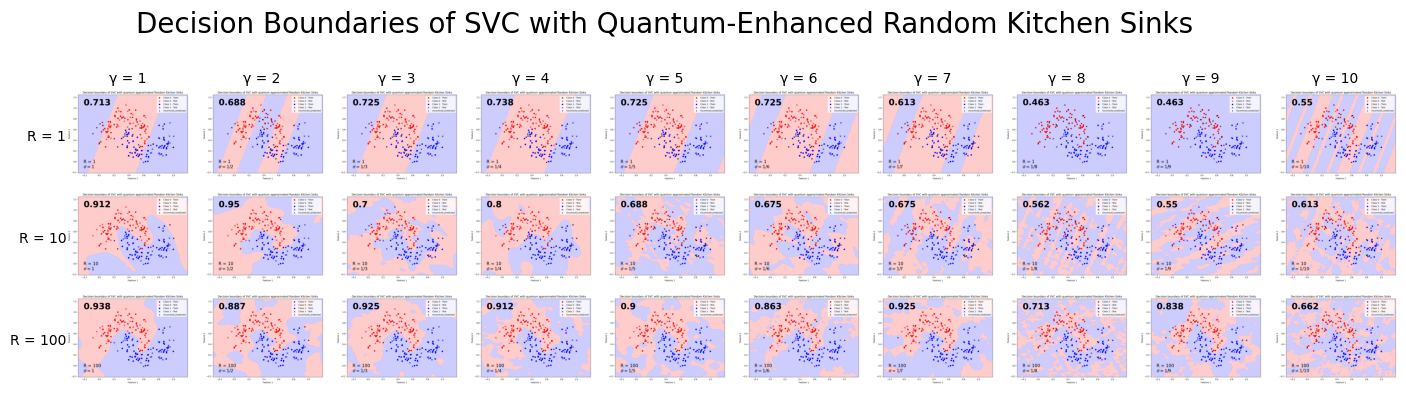

In [16]:
run_different_gamma_r(base_args, type="quantum")

Method 2: We can compare with the results when not training the hybrid model and simply using it for its intial output.


#############################
For r=1, gamma=1
q_rand_kitchen_sinks acc: 0.625

#############################
For r=1, gamma=2
q_rand_kitchen_sinks acc: 0.675

#############################
For r=1, gamma=3
q_rand_kitchen_sinks acc: 0.525

#############################
For r=1, gamma=4
q_rand_kitchen_sinks acc: 0.4625

#############################
For r=1, gamma=5
q_rand_kitchen_sinks acc: 0.4625

#############################
For r=1, gamma=6
q_rand_kitchen_sinks acc: 0.625

#############################
For r=1, gamma=7
q_rand_kitchen_sinks acc: 0.55

#############################
For r=1, gamma=8
q_rand_kitchen_sinks acc: 0.4625

#############################
For r=1, gamma=9
q_rand_kitchen_sinks acc: 0.4875

#############################
For r=1, gamma=10
q_rand_kitchen_sinks acc: 0.5875

#############################
For r=10, gamma=1
q_rand_kitchen_sinks acc: 0.9

#############################
For r=10, gamma=2
q_rand_kitchen_sinks acc: 0.8

#############################
For r=

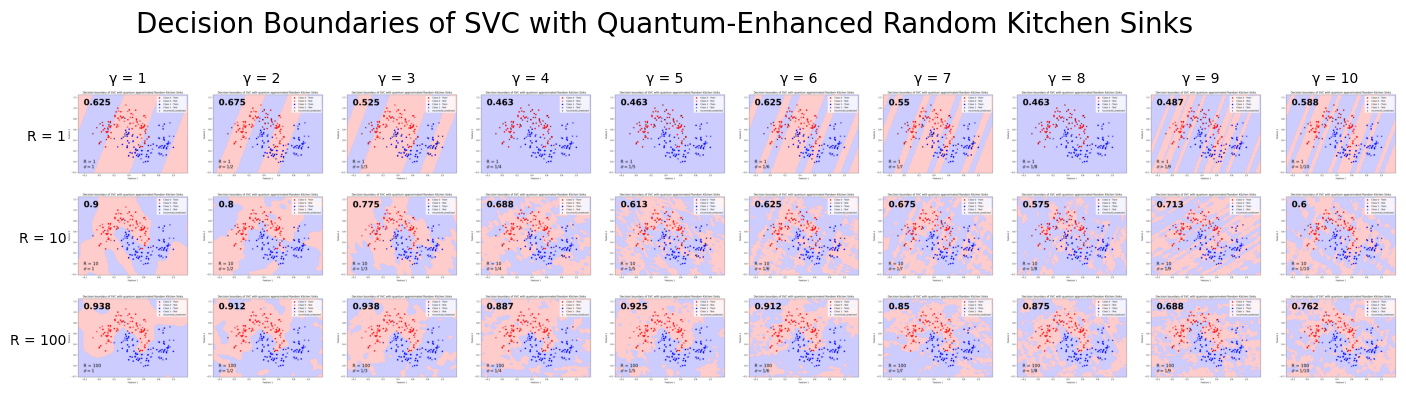

In [17]:
base_args.train_hybrid_model = False
run_different_gamma_r(base_args, type="quantum")

From this, we see that with the hyperparameters used, training the hybrid model does not make a big difference in the final decision boundary of the SVC.

Finally, let us compare with the classical random kitchen sinks algorithm.


#############################
For r=1, gamma=1
rand_kitchen_sinks acc: 0.7375

#############################
For r=1, gamma=2
rand_kitchen_sinks acc: 0.7375

#############################
For r=1, gamma=3
rand_kitchen_sinks acc: 0.7375

#############################
For r=1, gamma=4
rand_kitchen_sinks acc: 0.725

#############################
For r=1, gamma=5
rand_kitchen_sinks acc: 0.725

#############################
For r=1, gamma=6
rand_kitchen_sinks acc: 0.725

#############################
For r=1, gamma=7
rand_kitchen_sinks acc: 0.725

#############################
For r=1, gamma=8
rand_kitchen_sinks acc: 0.725

#############################
For r=1, gamma=9
rand_kitchen_sinks acc: 0.7375

#############################
For r=1, gamma=10
rand_kitchen_sinks acc: 0.725

#############################
For r=10, gamma=1
rand_kitchen_sinks acc: 0.8125

#############################
For r=10, gamma=2
rand_kitchen_sinks acc: 0.825

#############################
For r=10, gamma=3
rand_ki

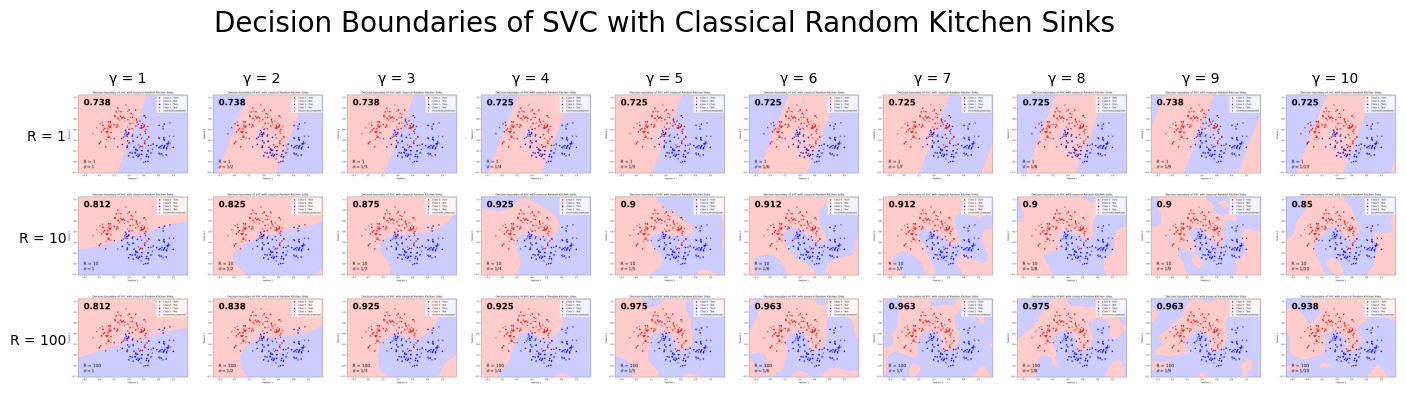

In [18]:
run_different_gamma_r(base_args, type="classical")

One can see  that the results obtained using the quantum enhanced version of the algorithm yields better test classification accuracies with small $\gamma$ than the ones obtained with the classical version. However, when $\gamma$ gets big, it is the opposite. Moreover, for both versions of the random kitchen sinks, we observe that increasing R increases the model's performance too since that parameters controls the precision of the approximated Gaussian kernel.\\

I now encourage you to experiment by modifying some hyperparameters. We chose to operate using 10 photons to replicate the results from [this paper](https://arxiv.org/abs/2107.05224) but we can obtain some interesting results using less photons:

`base_args.num_photon = 2`

Other than that, it also is interesting to use a more complex photonic circuit that is trainable:

`base_args.circuit = 'general'`

For better optimization of the hybrid model when training it, you can change the data used for optimization with:

`base_args.hybrid_model_data = 'Generated'`

This basically increases the amount of training data for the hybrid model instead of only using the moon dataset. It also spreads the data points used for training better on the domain between the minimum and the maximum values. With this setup for training, the quantum-enhanced random kitchen sinks algorithm is on par with the classical one.